# Machine Learning Pipelines


This notebook implements and explores gradient boosted trees and autoencoders.

###Setup

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=7a5c49e14ac7a6fc9e3a21f7d0b7243683f9915c6ec46ab9a9ae9a0f22e94473
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
## imports
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import time

## Gradient Boosted Trees

Implementation of a gradient-boosted tree regression model from scratch.

### Data

In [ ]:
cal_housing_train = pd.read_csv('sample_data/california_housing_train.csv')
cal_housing_test = pd.read_csv('sample_data/california_housing_test.csv')

### Model

In [ ]:
# Square loss for gradient boosted tree implementation
class SquareLoss():
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

In [ ]:
class my_GradientBoosting(object):
    """Super class of GradientBoostingClassifier and GradientBoostinRegressor.
    Uses a collection of regression trees that trains on predicting the gradient
    of the loss function.

    Parameters:
    -----------
    n_estimators: int
        The number of classification trees that are used.
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        The minimum impurity required to split the tree further.
    max_depth: int
        The maximum depth of a tree.
    regression: boolean
        True or false depending on if we're doing regression or classification.
    """
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression
        self.trees = []
        self.square_loss = SquareLoss()

    def fit(self, X, y):
        # Set initial predictions to be the mean
        self.initial_pred = np.mean(y, axis=0)
        preds = np.full(np.shape(y), self.initial_pred)

        # Loop through the number of trees
        for i in tqdm(range(self.n_estimators)):

            # Compute the residuals (Note: residuals are negative gradients)
            residuals = -self.square_loss.gradient(y, preds)

            # Fit tree to the current residuals
            self.trees.append(DecisionTreeRegressor(
                                min_samples_split = self.min_samples_split,
                                min_impurity_decrease = self.min_impurity,
                                max_depth = self.max_depth))
            self.trees[-1].fit(X, residuals)

            # Update predictions
            preds += self.learning_rate * self.trees[-1].predict(X)

    def predict(self, X):
        # Initalize predictions and refine with each tree
        preds = np.full(X.shape[0], self.initial_pred)
        for tree in self.trees:
            preds += self.learning_rate * tree.predict(X)
        return preds

In [ ]:
class my_GradientBoostingRegressor(my_GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=0.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=4, debug=False):

        super(my_GradientBoostingRegressor, self).__init__(
            n_estimators = n_estimators,
            learning_rate = learning_rate,
            min_samples_split = min_samples_split,
            min_impurity = min_var_red,
            max_depth = max_depth,
            regression = True
        )
        self.debug = debug

### Model fitting and evaluation

Train the Regressor

In [ ]:
# Split data into features and labels for training and testing
X_train = cal_housing_train.drop('median_house_value', axis=1).values
y_train = cal_housing_train['median_house_value'].values
X_test = cal_housing_test.drop('median_house_value', axis=1).values
y_test = cal_housing_test['median_house_value'].values

In [ ]:
# Initialize a Gradient Boosting Regressor and train it
my_gbr = my_GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            min_samples_split=2,
            min_var_red=1e-7,
            max_depth=3
        )
my_gbr_start_time = time.time()
my_gbr.fit(X_train, y_train)
my_gbr_end_time = time.time()

100%|██████████| 100/100 [00:04<00:00, 21.31it/s]


Evaluate Regressor on the test dataset

In [ ]:
# Evaluate the RMSE as well as the model training time
my_gbr_preds = my_gbr.predict(X_test)
my_gbr_rmse = mean_squared_error(y_test, my_gbr_preds, squared=False)
print("RMSE of my Gradient Boosting Regressor implementation:", my_gbr_rmse)
print("Training time of my Gradient Boosting Regressor implementation:", my_gbr_end_time - my_gbr_start_time, "seconds")

RMSE of my Gradient Boosting Regressor implementation: 55209.3777250606
Training time of my Gradient Boosting Regressor implementation: 4.700582027435303 seconds


Evaluate regressor's performance against scikit-learn's and Spark's implementation (using the same set of hyperparameters)

In [ ]:
### Scikit Learn's Implementation ###

from sklearn.ensemble import GradientBoostingRegressor

# Initialize a Gradient Boosting Regressor
sk_gbr = GradientBoostingRegressor(
                    loss = 'squared_error',
                    n_estimators = 100,
                    learning_rate = 0.1,
                    min_samples_split = 2,
                    min_impurity_decrease = 0,
                    max_depth = 3
                )

# Training
sk_gbr_start_time = time.time()
sk_gbr.fit(X_train, y_train)
sk_gbr_end_time = time.time()

# Predictions
sk_gbr_preds = sk_gbr.predict(X_test)

# Evaluate the RMSE as well as the model training time
sk_gbr_rmse = mean_squared_error(y_test, sk_gbr_preds, squared=False)
print("RMSE of Scikit Learn's Gradient Boosting Regressor implementation:", sk_gbr_rmse)
print("Training time of Scikit Learn's Gradient Boosting Regressor implementation:", sk_gbr_end_time - sk_gbr_start_time, "seconds")

RMSE of Scikit Learn's Gradient Boosting Regressor implementation: 55209.377725060614
Training time of Scikit Learn's Gradient Boosting Regressor implementation: 3.566077947616577 seconds


In [ ]:
### Spark's Implementation ###

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# Convert datasets to spark dataframes
train_spark = spark.createDataFrame(cal_housing_train)
test_spark = spark.createDataFrame(cal_housing_test)

# Get features for training
features = cal_housing_train.columns.tolist()
features.remove("median_house_value")
featureAssembler = VectorAssembler(inputCols=features, outputCol="features")

# Intialize a Gradient Boosting Regressor
gbt = GBTRegressor(
        labelCol = "median_house_value",
        featuresCol="features",
        maxDepth=3,
        minInstancesPerNode=2,
        minInfoGain=0.0,
        maxIter=100,
        stepSize=0.1,
        lossType="squared"
    )
# Chain indexer and GBT in a Pipeline
pipeline = Pipeline(stages=[featureAssembler, gbt])

# Training
spark_gbr_start_time = time.time()
spark_gbr = pipeline.fit(train_spark)
spark_gbr_end_time = time.time()

# Make predictions
spark_gbr_preds = spark_gbr.transform(test_spark)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="median_house_value",
    predictionCol="prediction",
    metricName="rmse",
)
spark_gbr_rmse = evaluator.evaluate(spark_gbr_preds)

print("RMSE of Spark's Gradient Boosting Regressor implementation:", spark_gbr_rmse)
print("Training time of Spark's Gradient Boosting Regressor implementation:", spark_gbr_end_time - spark_gbr_start_time, "seconds")

spark.stop()

RMSE of Spark's Gradient Boosting Regressor implementation: 55377.23156039809
Training time of Spark's Gradient Boosting Regressor implementation: 77.13829231262207 seconds


The results of each implementation of the Gradient Boosted Tree Regressor are summarized in the table below. It can be seen that my implementation and Scikit Learn's implementation had very similar RMSE and training time while Spark's implementation had a slightly lower RMSE but higher training time.

| Method              | RMSE        | Training time (s) |
|---------------------|-------------|-------------------|
| My Implementation   | 55209.38    | 4.70              |
| Scikit Learn        | 55209.48    | 5.57              |
| Spark               | 55200.07    | 47.10             |

## Autoencoder

Implementation of a simple feedforward antoencoder for images using PyTorch from scratch. The autoencoder has two hidden layers for both the encoder and decoder with a latent space of size 64.

### Data

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# datasets
minist_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

minist_test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# dataloader
batch_size = 100

train_loader = DataLoader(dataset=minist_training_data,shuffle=True,batch_size=batch_size)
test_loader = DataLoader(dataset=minist_test_data,shuffle=True,batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 143173952.06it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 51372219.60it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44693912.95it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4042123.65it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Model

In [ ]:
# AutoEncoder Class
class my_AutoEncoder(nn.Module):
    def __init__(self):
        super(my_AutoEncoder, self).__init__()

        self.latent_dim = 64
        self.input_size = 28*28
        self.hidden_dim1 = 512
        self.hidden_dim2 = 128

        self.learning_rate = 0.001

        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        # build an encoder with two hidden layers

        encoder = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_dim1),
            nn.ReLU(),
            nn.Linear(self.hidden_dim1, self.hidden_dim2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim2, self.latent_dim)
        )

        return encoder

    def build_decoder(self):
        # build a decoder with two hidden layers

        decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.hidden_dim2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim2, self.hidden_dim1),
            nn.ReLU(),
            nn.Linear(self.hidden_dim1, self.input_size)
        )

        return decoder

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def train(self, n_epochs=5, save_interval=100):
        # We will train with MSE loss and Adam optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        n_total_steps = len(train_loader)

        # Training loop
        lossval = []
        for j in range(n_epochs):
            for i, (x_train, y_train) in enumerate(train_loader):
                #prediction
                y_pred = self(x_train.reshape(-1, 28*28))

                #calculating loss
                loss = criterion(y_pred, x_train.reshape(-1, 28*28))

                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #print batch information
                if (i+1) % 100 == 0:
                    print (f'Epoch [{j+1}/{n_epochs}], Step[{i+1}/{n_total_steps}], MSE Loss: {loss.item():.4f}')
                    lossval.append(loss.item())

        return y_pred, lossval

### Model Training and Evaluation

Train the autoencoder on the MNIST data for 5 epochs.

In [ ]:
# Train the autoencoder
my_ae = my_AutoEncoder()
outputs, losses = my_ae.train()

Epoch [1/5], Step[100/600], MSE Loss: 0.0375
Epoch [1/5], Step[200/600], MSE Loss: 0.0268
Epoch [1/5], Step[300/600], MSE Loss: 0.0220
Epoch [1/5], Step[400/600], MSE Loss: 0.0203
Epoch [1/5], Step[500/600], MSE Loss: 0.0192
Epoch [1/5], Step[600/600], MSE Loss: 0.0178
Epoch [2/5], Step[100/600], MSE Loss: 0.0159
Epoch [2/5], Step[200/600], MSE Loss: 0.0155
Epoch [2/5], Step[300/600], MSE Loss: 0.0143
Epoch [2/5], Step[400/600], MSE Loss: 0.0137
Epoch [2/5], Step[500/600], MSE Loss: 0.0132
Epoch [2/5], Step[600/600], MSE Loss: 0.0119
Epoch [3/5], Step[100/600], MSE Loss: 0.0122
Epoch [3/5], Step[200/600], MSE Loss: 0.0117
Epoch [3/5], Step[300/600], MSE Loss: 0.0132
Epoch [3/5], Step[400/600], MSE Loss: 0.0118
Epoch [3/5], Step[500/600], MSE Loss: 0.0105
Epoch [3/5], Step[600/600], MSE Loss: 0.0111
Epoch [4/5], Step[100/600], MSE Loss: 0.0107
Epoch [4/5], Step[200/600], MSE Loss: 0.0104
Epoch [4/5], Step[300/600], MSE Loss: 0.0098
Epoch [4/5], Step[400/600], MSE Loss: 0.0100
Epoch [4/5

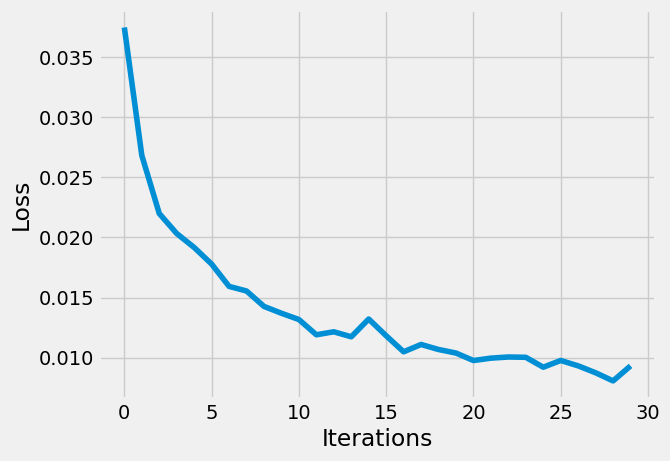

In [ ]:
# Vizualize training loss
import matplotlib.pyplot as plt
%matplotlib inline

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)

Next we extract the trained latent representations of the training data and train a simple scikit-learn's random forest model on the representations and evaluate using the accuracy and f1 scores.


In [ ]:
# Extracting the latent represntations of each input
representations = []
y = []

for x_train, y_train in train_loader:
    with torch.no_grad():
        latent_representation = my_ae.encoder(x_train.reshape(-1, 28*28))
    representations.append(latent_representation)
    y.append(y_train)

# Converting to numpy
representations = torch.cat(representations, dim=0).numpy()
y = torch.cat(y, dim=0).numpy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

sk_clf = RandomForestClassifier(n_estimators = 20, max_features = 20,
                   min_samples_split = 2, min_impurity_decrease = 0,
                   max_depth = None, max_samples = 0.05)


# Training the random forest model on the latent representations
sk_clf.fit(representations, y)

RandomForestClassifier(max_features=20, max_samples=0.05,
                       min_impurity_decrease=0, n_estimators=20)

In [ ]:
# Make predictions with Random Forest Classifier
test_data = []
test_labels = []

# Get latent representations for each test input
for x_test, y_test in test_loader:
    with torch.no_grad():
        latent_representation = my_ae.encoder(x_test.reshape(-1, 28*28))
    test_data.append(latent_representation)
    test_labels.append(y_test)

# Convert to numpy
test_data = torch.cat(test_data, dim=0).numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

# Predict with Random Forest Classifier
y_pred_sk = sk_clf.predict(test_data)

In [ ]:
# Print classification report
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(test_labels, y_pred_sk))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       980
           1       0.95      0.98      0.96      1135
           2       0.89      0.90      0.90      1032
           3       0.85      0.88      0.86      1010
           4       0.88      0.91      0.89       982
           5       0.88      0.82      0.85       892
           6       0.93      0.94      0.93       958
           7       0.92      0.91      0.91      1028
           8       0.87      0.83      0.85       974
           9       0.88      0.84      0.86      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



The accuracy was 0.90 and the average f1-score was 0.90.

The below table summarizes the accuracy and f1-score on the test set for the random forest classifiers we implemented in the assignment and in the lab.

It can be seen that this model that uses the latent representations performs better than both our own random forest implementation as well as spark's random forest implementation that we used in the lab. It would be difficult to assess the differences in the performances in between these models as our current model was implemented with scikit learn and from the lab we also saw that scikit learn outperformed the other implementations. Therefore it is likely that the increase in performance was due to scikit learn's optimizations rather than the use of the latent representations.

However, this model performed slightly worse than the scikit learn's random forest model that was used in the lab. This slight decrease in performance on scikit learn's model could be because our latent representations might be too small or not fully optimized to represent our input data well, leading to decreased accuracy.

| Model                           | Accuracy  | F1-Score  |
|---------------------------------|-----------|-----------|
| A2 with latent representations  | 0.90      | 0.90      |
| Lab2 Our Implementation         | 0.79      | 0.79      |
| Lab2 Scikit Learn               | 0.92      | 0.92      |
| Lab2 Spark                      | 0.83      | 0.83      |

### Experiments

Experiments with different hidden layer and latent space dimensions for the AutoEncoder.

In [ ]:
# Changing latent space dimensions and retraining the autoencoder.

# Create a new child AutoEncoder class
class my_AutoEncoder_2(my_AutoEncoder):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, input_size=28*28, learning_rate=0.001):
        super(my_AutoEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.input_size = input_size
        self.learning_rate = learning_rate

        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

The autoencoder was retrained with 3 different latent space dimensions and it was found that the MSE loss decreased as the latent space dimensions increased (the results are summarized in the table below). This makes sense because with a larger latent space dimension, we are able to encode more of the original image information.

| Latent Dimension | Hidden Layer 1 Dimension | Hidden Layer 2 Dimension | MSE  |
|------------------|--------------------------|---------|---------|
| 128              | 512                      | 256     | 0.0075  |
| 32               | 512                      | 128     | 0.0107  |
| 16               | 512                      | 128     | 0.0135  |

In [ ]:
ae_1 = my_AutoEncoder_2(latent_dim=128, hidden_dim1=512, hidden_dim2=256)
outputs, losses = ae_1.train()

Epoch [1/5], Step[100/600], MSE Loss: 0.0399
Epoch [1/5], Step[200/600], MSE Loss: 0.0281
Epoch [1/5], Step[300/600], MSE Loss: 0.0241
Epoch [1/5], Step[400/600], MSE Loss: 0.0189
Epoch [1/5], Step[500/600], MSE Loss: 0.0181
Epoch [1/5], Step[600/600], MSE Loss: 0.0164
Epoch [2/5], Step[100/600], MSE Loss: 0.0143
Epoch [2/5], Step[200/600], MSE Loss: 0.0149
Epoch [2/5], Step[300/600], MSE Loss: 0.0136
Epoch [2/5], Step[400/600], MSE Loss: 0.0127
Epoch [2/5], Step[500/600], MSE Loss: 0.0118
Epoch [2/5], Step[600/600], MSE Loss: 0.0119
Epoch [3/5], Step[100/600], MSE Loss: 0.0107
Epoch [3/5], Step[200/600], MSE Loss: 0.0100
Epoch [3/5], Step[300/600], MSE Loss: 0.0104
Epoch [3/5], Step[400/600], MSE Loss: 0.0098
Epoch [3/5], Step[500/600], MSE Loss: 0.0091
Epoch [3/5], Step[600/600], MSE Loss: 0.0086
Epoch [4/5], Step[100/600], MSE Loss: 0.0085
Epoch [4/5], Step[200/600], MSE Loss: 0.0090
Epoch [4/5], Step[300/600], MSE Loss: 0.0085
Epoch [4/5], Step[400/600], MSE Loss: 0.0090
Epoch [4/5

In [ ]:
ae_2 = my_AutoEncoder_2(latent_dim=32, hidden_dim1=512, hidden_dim2=128)
outputs, losses = ae_2.train()

Epoch [1/5], Step[100/600], MSE Loss: 0.0412
Epoch [1/5], Step[200/600], MSE Loss: 0.0293
Epoch [1/5], Step[300/600], MSE Loss: 0.0250
Epoch [1/5], Step[400/600], MSE Loss: 0.0215
Epoch [1/5], Step[500/600], MSE Loss: 0.0206
Epoch [1/5], Step[600/600], MSE Loss: 0.0190
Epoch [2/5], Step[100/600], MSE Loss: 0.0184
Epoch [2/5], Step[200/600], MSE Loss: 0.0162
Epoch [2/5], Step[300/600], MSE Loss: 0.0150
Epoch [2/5], Step[400/600], MSE Loss: 0.0156
Epoch [2/5], Step[500/600], MSE Loss: 0.0145
Epoch [2/5], Step[600/600], MSE Loss: 0.0126
Epoch [3/5], Step[100/600], MSE Loss: 0.0133
Epoch [3/5], Step[200/600], MSE Loss: 0.0143
Epoch [3/5], Step[300/600], MSE Loss: 0.0140
Epoch [3/5], Step[400/600], MSE Loss: 0.0131
Epoch [3/5], Step[500/600], MSE Loss: 0.0142
Epoch [3/5], Step[600/600], MSE Loss: 0.0119
Epoch [4/5], Step[100/600], MSE Loss: 0.0116
Epoch [4/5], Step[200/600], MSE Loss: 0.0118
Epoch [4/5], Step[300/600], MSE Loss: 0.0122
Epoch [4/5], Step[400/600], MSE Loss: 0.0115
Epoch [4/5

In [ ]:
ae_3 = my_AutoEncoder_2(latent_dim=16, hidden_dim1=512, hidden_dim2=128)
outputs, losses = ae_3.train()

Epoch [1/5], Step[100/600], MSE Loss: 0.0417
Epoch [1/5], Step[200/600], MSE Loss: 0.0310
Epoch [1/5], Step[300/600], MSE Loss: 0.0264
Epoch [1/5], Step[400/600], MSE Loss: 0.0251
Epoch [1/5], Step[500/600], MSE Loss: 0.0226
Epoch [1/5], Step[600/600], MSE Loss: 0.0218
Epoch [2/5], Step[100/600], MSE Loss: 0.0203
Epoch [2/5], Step[200/600], MSE Loss: 0.0201
Epoch [2/5], Step[300/600], MSE Loss: 0.0175
Epoch [2/5], Step[400/600], MSE Loss: 0.0172
Epoch [2/5], Step[500/600], MSE Loss: 0.0174
Epoch [2/5], Step[600/600], MSE Loss: 0.0159
Epoch [3/5], Step[100/600], MSE Loss: 0.0164
Epoch [3/5], Step[200/600], MSE Loss: 0.0165
Epoch [3/5], Step[300/600], MSE Loss: 0.0156
Epoch [3/5], Step[400/600], MSE Loss: 0.0168
Epoch [3/5], Step[500/600], MSE Loss: 0.0140
Epoch [3/5], Step[600/600], MSE Loss: 0.0149
Epoch [4/5], Step[100/600], MSE Loss: 0.0145
Epoch [4/5], Step[200/600], MSE Loss: 0.0145
Epoch [4/5], Step[300/600], MSE Loss: 0.0140
Epoch [4/5], Step[400/600], MSE Loss: 0.0145
Epoch [4/5